<a href="https://colab.research.google.com/github/HenriqueCF8896/MNCM/blob/main/Programa5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SIMULAÇÃO DE DISTRIBUIÇÃO DE TEMPERATURA EM COMBUSTÍVEL NUCLEAR
Parâmetros numéricos:
- Nós espaciais: 100
- Passo espacial: 0.000101 m
- Passo temporal: 0.0100 s
- Número de Fourier: 4.9005
- Número de Biot: 0.0037

Iniciando simulação temporal...
  - Armazenado resultado para t = 1.0 s
  - Armazenado resultado para t = 5.0 s
  - Armazenado resultado para t = 7.0 s
  - Armazenado resultado para t = 10.0 s
  - Armazenado resultado para t = 15.0 s
  - Armazenado resultado para t = 20.0 s
  - Armazenado resultado para t = 30.0 s


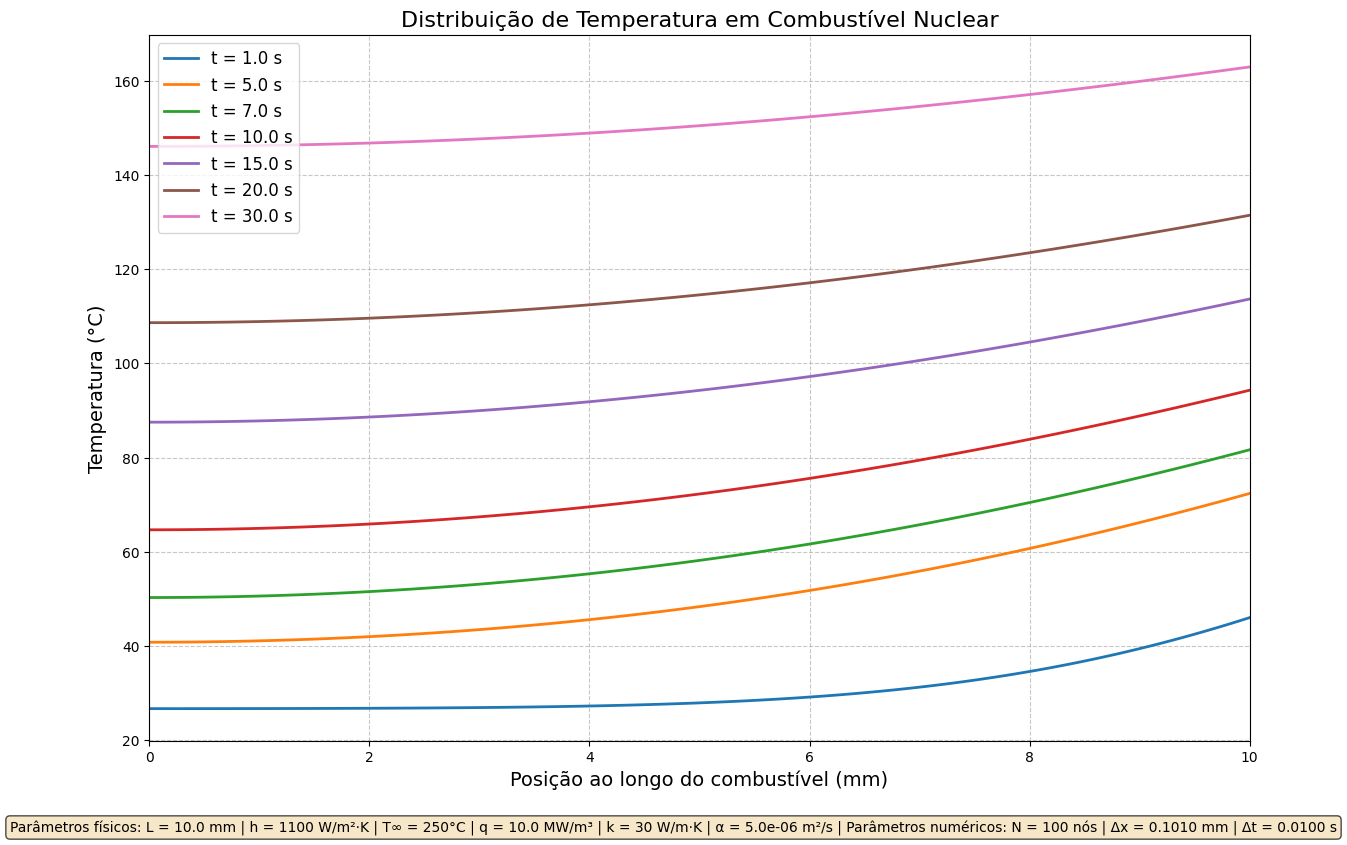


Simulação concluída! Resultados salvos em 'distribuicao_temperatura_nuclear.png'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def thomas_algorithm(a, b, c, d):
    """
    Resolve um sistema tridiagonal Ax = d usando o algoritmo de Thomas.

    Parâmetros:
        a : array - subdiagonal (elementos a[0] a[n-2], tamanho n-1)
        b : array - diagonal principal (tamanho n)
        c : array - superdiagonal (elementos c[0] a[n-2], tamanho n-1)
        d : array - vetor de termos independentes (tamanho n)

    Retorna:
        x : array - vetor solução (tamanho n)
    """
    n = len(d)
    # Cria cópias para não modificar os originais
    b_prime = np.copy(b)
    d_prime = np.copy(d)

    # Fase de eliminação
    for i in range(1, n):
        m = a[i-1] / b_prime[i-1]
        b_prime[i] = b_prime[i] - m * c[i-1]
        d_prime[i] = d_prime[i] - m * d_prime[i-1]

    # Fase de substituição reversa
    x = np.zeros(n)
    x[-1] = d_prime[-1] / b_prime[-1]  # Último elemento

    for i in range(n-2, -1, -1):
        x[i] = (d_prime[i] - c[i] * x[i+1]) / b_prime[i]

    return x

def resolver_distribuicao_temperatura():
    """Resolve a equação do calor transiente 1D em combustível nuclear"""
    # =====================================================================
    # 1. PARÂMETROS FÍSICOS (conforme especificação do problema)
    # =====================================================================
    L = 0.01           # Comprimento do combustível (10 mm convertido para metros)
    h = 1100           # Coeficiente de transferência de calor (W/m²·K)
    T_inf = 250        # Temperatura do fluido refrigerante (°C)
    q_dot = 1e7        # Geração de calor (W/m³)
    k = 30             # Condutividade térmica (W/m·K)
    alpha = 5e-6       # Difusividade térmica (m²/s)
    T0 = 25            # Temperatura inicial (°C)

    # =====================================================================
    # 2. DISCRETIZAÇÃO ESPACIAL E TEMPORAL
    # =====================================================================
    N = 100            # Número de nós espaciais
    dx = L / (N-1)     # Tamanho do intervalo espacial
    dt = 0.01          # Passo de tempo (s) - escolhido para estabilidade
    Fo = alpha * dt / dx**2  # Número de Fourier
    Bi = h * dx / k    # Número de Biot

    print(f"Parâmetros numéricos:")
    print(f"- Nós espaciais: {N}")
    print(f"- Passo espacial: {dx:.6f} m")
    print(f"- Passo temporal: {dt:.4f} s")
    print(f"- Número de Fourier: {Fo:.4f}")
    print(f"- Número de Biot: {Bi:.4f}")

    # =====================================================================
    # 3. INICIALIZAÇÃO E CONFIGURAÇÃO
    # =====================================================================
    # Inicialização da temperatura em todos os nós
    T = np.ones(N) * T0

    # Tempos solicitados para plotagem (em segundos)
    tempos_solicitados = [1, 5, 7, 10, 15, 20, 30]
    resultados = []  # Armazenará (tempo, distribuição de temperatura)
    x = np.linspace(0, L, N)  # Posições ao longo do combustível

    # =====================================================================
    # 4. LOOP TEMPORAL PRINCIPAL
    # =====================================================================
    tempo_maximo = max(tempos_solicitados)
    passos_temporais = int(tempo_maximo / dt)

    print("\nIniciando simulação temporal...")
    for passo in range(passos_temporais + 1):
        tempo_atual = passo * dt

        # Construir vetores do sistema tridiagonal
        a = np.zeros(N)    # Subdiagonal (elementos abaixo da diagonal)
        b = np.zeros(N)    # Diagonal principal
        c = np.zeros(N)    # Superdiagonal (elementos acima da diagonal)
        d_val = np.zeros(N) # Termos independentes

        # Constante do termo de geração
        S = (q_dot * dx**2 * Fo) / k

        # =================================================================
        # 5. APLICAR CONDIÇÕES DE CONTORNO E EQUAÇÕES PARA NÓS INTERNOS
        # =================================================================

        # a) Nó esquerdo (i=0): condição adiabática (dT/dx = 0)
        b[0] = 1 + 2*Fo
        c[0] = -2*Fo
        d_val[0] = T[0] + S

        # b) Nós internos (i=1 a i=N-2)
        for i in range(1, N-1):
            a[i] = -Fo          # Coeficiente para T_{i-1}
            b[i] = 1 + 2*Fo     # Coeficiente para T_i
            c[i] = -Fo          # Coeficiente para T_{i+1}
            d_val[i] = T[i] + S

        # c) Nó direito (i=N-1): convecção com o ambiente
        a[-1] = -2*Fo
        b[-1] = 1 + 2*Fo + 2*Fo*Bi
        d_val[-1] = T[-1] + 2*Fo*Bi*T_inf + S

        # =================================================================
        # 6. RESOLVER SISTEMA TRIDIAGONAL COM ALGORITMO DE THOMAS
        # =================================================================
        # Nota: a[0] não é usado (primeiro elemento da subdiagonal começa em i=1)
        T_novo = thomas_algorithm(a[1:], b, c[:-1], d_val)

        # Atualizar solução para próximo passo
        T = T_novo.copy()

        # =================================================================
        # 7. ARMAZENAR RESULTADOS NOS TEMPOS SOLICITADOS
        # =================================================================
        if any(abs(tempo_atual - t) < dt/2 for t in tempos_solicitados):
            resultados.append((tempo_atual, T.copy()))
            print(f"  - Armazenado resultado para t = {tempo_atual:.1f} s")

    # =====================================================================
    # 8. VISUALIZAÇÃO DOS RESULTADOS (AJUSTADA PARA PROPRIEDADES FORA DO GRID)
    # =====================================================================
    # Criar figura com espaço adicional na parte inferior
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111)

    # Plotar distribuição de temperatura para cada tempo armazenado
    for tempo, T_dist in resultados:
        ax.plot(x * 1000, T_dist, linewidth=2, label=f"t = {tempo:.1f} s")

    # Configurações do gráfico
    ax.set_title("Distribuição de Temperatura em Combustível Nuclear", fontsize=16)
    ax.set_xlabel("Posição ao longo do combustível (mm)", fontsize=14)
    ax.set_ylabel("Temperatura (°C)", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12, loc='upper left')
    ax.set_xlim(0, L*1000)

    # Adicionar informações dos parâmetros FORA DO GRID (na parte inferior)
    param_text = (
        f"Parâmetros físicos: "
        f"L = {L*1000:.1f} mm | h = {h} W/m²·K | T∞ = {T_inf}°C | "
        f"q = {q_dot/1e6:.1f} MW/m³ | k = {k} W/m·K | α = {alpha:.1e} m²/s | "
        f"Parâmetros numéricos: N = {N} nós | Δx = {dx*1000:.4f} mm | Δt = {dt:.4f} s"
    )

    # Posicionar texto na parte inferior da figura, fora do gráfico
    plt.figtext(0.5, 0.02, param_text, ha='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    # Ajustar layout para reservar espaço para o texto
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    plt.savefig('distribuicao_temperatura_nuclear.png', dpi=300, bbox_inches='tight')
    plt.show()

    return resultados

# Executar a simulação
if __name__ == "__main__":
    print("="*70)
    print("SIMULAÇÃO DE DISTRIBUIÇÃO DE TEMPERATURA EM COMBUSTÍVEL NUCLEAR")
    print("="*70)
    resultados = resolver_distribuicao_temperatura()
    print("\nSimulação concluída! Resultados salvos em 'distribuicao_temperatura_nuclear.png'")

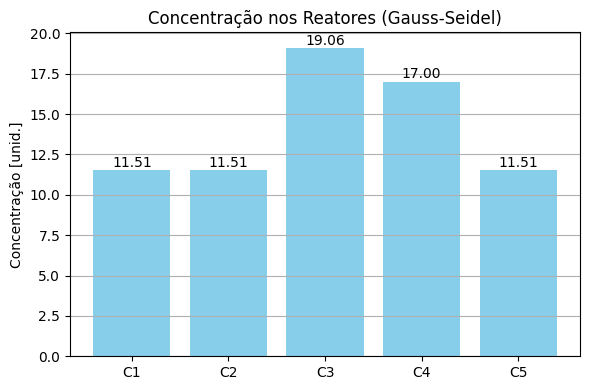

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------
# PROBLEMA 1: SISTEMA LINEAR - GAUSS-SEIDEL
# -----------------------------------------------
A1 = np.array([
    [6, 0, -1, 0, 0],
    [-3, 3, 0, 0, 0],
    [0, -1, 9, 0, 0],
    [0, -1, -8, 11, -2],
    [-3, -1, 0, 0, 4]
])
b1 = np.array([50, 0, 160, 0, 0])
n1 = len(b1)

# Parâmetros de Gauss-Seidel
tolerance = 1e-6
max_iterations = 1000
x_gs = np.zeros(n1)

# Método de Gauss-Seidel
for iteration in range(max_iterations):
    x_new = np.copy(x_gs)
    for i in range(n1):
        sum1 = np.dot(A1[i, :i], x_new[:i])
        sum2 = np.dot(A1[i, i+1:], x_gs[i+1:])
        x_new[i] = (b1[i] - sum1 - sum2) / A1[i, i]
    if np.linalg.norm(x_new - x_gs, ord=np.inf) < tolerance:
        break
    x_gs = x_new
gs_solution = x_gs
gs_iterations = iteration + 1
#------------------------------------------------
# VISUALIZAÇÃO DO PROBLEMA 1
#------------------------------------------------

reatores = [f"C{i+1}" for i in range(5)]
concentracoes = gs_solution.tolist()

plt.figure(figsize=(6, 4))
plt.bar(reatores, concentracoes, color='skyblue')
plt.title("Concentração nos Reatores (Gauss-Seidel)")
plt.ylabel("Concentração [unid.]")
plt.ylim(0, max(concentracoes) + 1)
for i, val in enumerate(concentracoes):
    plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom')
plt.grid(axis='y')
plt.tight_layout()
plt.show()